# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импортируем библиотеки

In [ ]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 46 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [ ]:
import pandas as pd
import numpy as np

import datetime

from catboost import CatBoostClassifier

from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import timeit

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Загрузка данных

In [ ]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Признаки

`DateCrawled` — дата скачивания анкеты из базы

`VehicleType` — тип автомобильного кузова

`RegistrationYear` — год регистрации автомобиля

`Gearbox` — тип коробки передач

`Power` — мощность (л. с.)

`Model` — модель автомобиля

`Kilometer` — пробег (км)

`RegistrationMonth` — месяц регистрации автомобиля

`FuelType` — тип топлива

`Brand` — марка автомобиля

`Repaired` — была машина в ремонте или нет

`DateCreated` — дата создания анкеты

`NumberOfPictures` — количество фотографий автомобиля

`PostalCode` — почтовый индекс владельца анкеты (пользователя)

`LastSeen` — дата последней активности пользователя

Целевой признак

`Price` — цена (евро)

###  Исследование данных

In [ ]:
print(df.info())
print('\n\nДубликаты:', df.duplicated().sum())
print('\n\nПропущенные значения:\n\n', df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
df[df.duplicated(keep=False)].sort_values(by='DateCreated')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


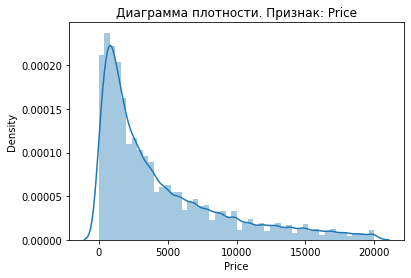

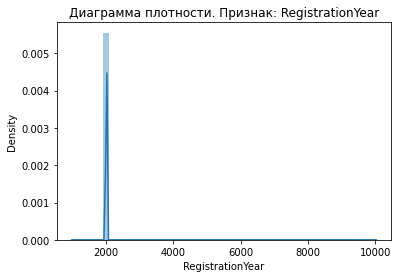

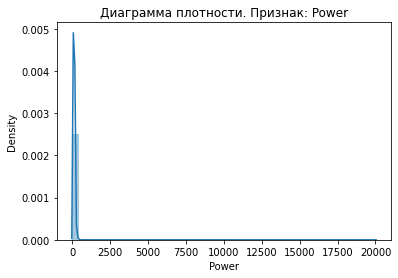

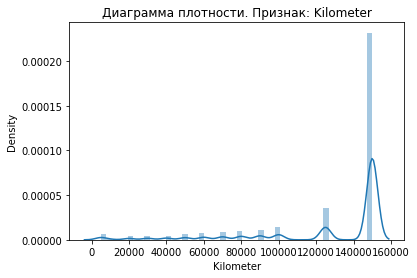

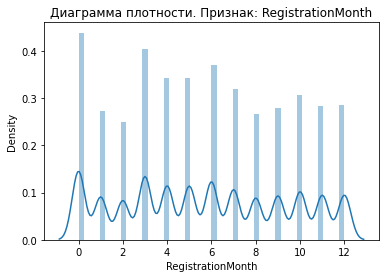

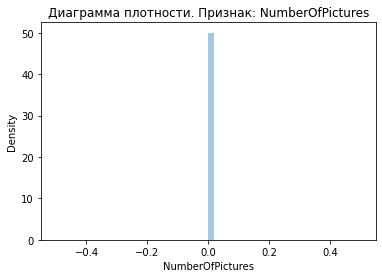

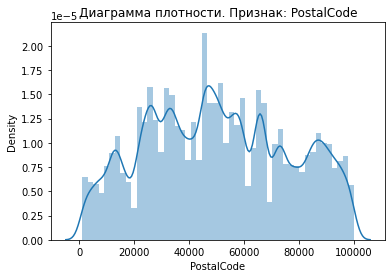

In [ ]:
for i in df.select_dtypes(include=np.number).columns:
    sns.distplot(df[i])
    plt.title(f'Диаграмма плотности. Признак: {i}')
    plt.show()

In [ ]:
df['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

<AxesSubplot:title={'center':'Корреляция признаков'}>

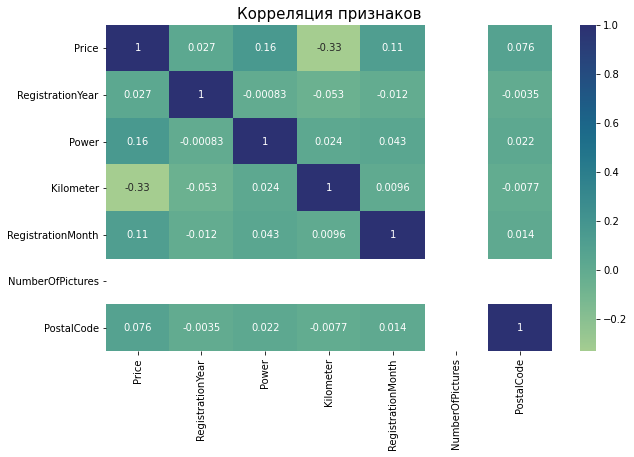

In [ ]:
plt.figure(figsize = (10, 6));
plt.title('Корреляция признаков', fontsize = 15)
sns.heatmap(df.corr(), annot = True, cmap="crest")

Данные содержат 15 признаков, `Price` - целевой признак, 354369 строк. 4 явных дубликата удалим, пропуски в данных исследуем и заменим либо удалим. Присутствуют нулевые и неадекватные значения, исследуем. Мультиколлинеарность не обнаружена. Признаки `DateCrawled`, `NumberOfPictures` и  `LastSeen` удалим сразу, как ненужные ни для исследования, ни для построения модели.

### Предобработка данных

Удалим дубликаты

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Удалим признаки

In [ ]:
df = df.drop(['DateCrawled', 'NumberOfPictures', 'LastSeen'], axis=1)
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'DateCreated', 'PostalCode'],
      dtype='object')

Обработаем целевой признак

In [ ]:
df['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

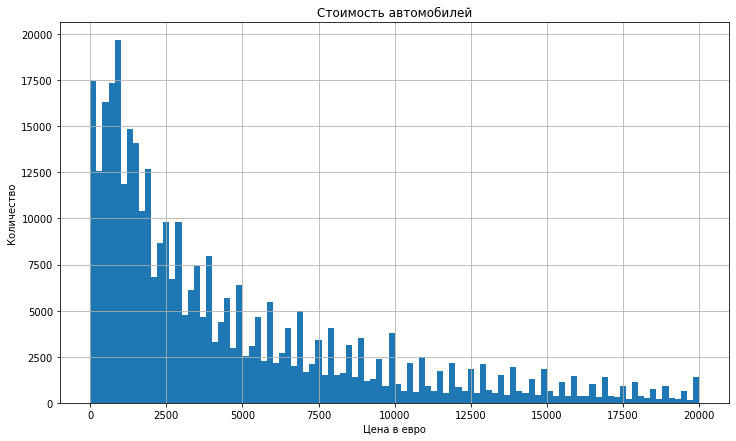

In [ ]:
df['Price'].hist(bins=100,figsize=(12,7))
plt.title('Стоимость автомобилей')
plt.xlabel('Цена в евро')
plt.ylabel('Количество')
plt.show()

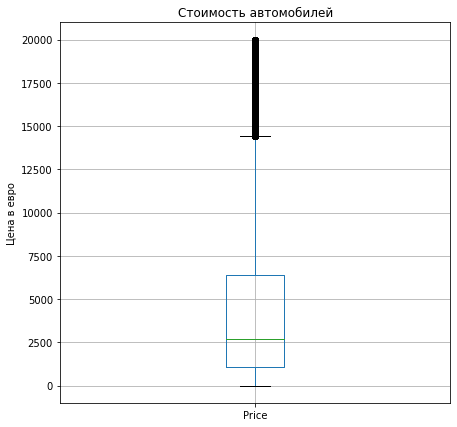

In [ ]:
df.boxplot(['Price'], figsize=(7,7))
plt.title('Стоимость автомобилей')
plt.ylabel('Цена в евро')
plt.show()

In [ ]:
q = [0.05, 0.95]
df['Price'].quantile(q=q)

0.05      200.0
0.95    14600.0
Name: Price, dtype: float64

Удалим строки с очень низкой и очень высокой ценой

In [ ]:
print(df.loc[df['Price'] < 200]['Price'].count())
print(df.loc[df['Price'] > 14600.0]['Price'].count())

17462
17652


In [ ]:
df=df.query('200 <= Price <=14600')
print(df.shape[0])

319251


In [ ]:
df.isna().sum()

Price                    0
VehicleType          30829
RegistrationYear         0
Gearbox              15292
Power                    0
Model                16011
Kilometer                0
RegistrationMonth        0
FuelType             26689
Brand                    0
Repaired             61217
DateCreated              0
PostalCode               0
dtype: int64

Пропуски в `VehicleType` заменим на 'unknown', тк нет данных для замены

In [ ]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox              15292
Power                    0
Model                16011
Kilometer                0
RegistrationMonth        0
FuelType             26689
Brand                    0
Repaired             61217
DateCreated              0
PostalCode               0
dtype: int64

Пропуски в `Model` удалим, тк заменить их не представляется возможным

In [ ]:
df = df.dropna(subset=['Model'])
df.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox              12749
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType             21482
Brand                    0
Repaired             54420
DateCreated              0
PostalCode               0
dtype: int64

Пропуски в `Gearbox` заменим на наиболее часто встречающиеся в модели

In [ ]:
df['Gearbox'] = df['Gearbox'].fillna(df.groupby('Model')['Gearbox'].transform(lambda x: x.value_counts().idxmax()))
df.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType             21482
Brand                    0
Repaired             54420
DateCreated              0
PostalCode               0
dtype: int64

Пропуски в `FuelType` заполним по аналогии с `Gearbox`

In [ ]:
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))
df.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             54420
DateCreated              0
PostalCode               0
dtype: int64

Пропуски в `Repaired` заменим на 'unknown'

In [ ]:
df['Repaired'] = df['Repaired'].fillna('unknown')
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
PostalCode           0
dtype: int64

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,303240.000000,303240.000000,303240.000000,303240.000000,303240.000000,303240.000000
mean,4007.770330,2003.481539,109.223434,130655.520380,5.870881,50622.676639
std,3527.515453,52.320769,183.589495,35061.353265,3.661470,25668.467271
min,200.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1200.000000,1999.000000,71.000000,125000.000000,3.000000,30451.000000
50%,2800.000000,2003.000000,103.000000,150000.000000,6.000000,49504.000000
75%,5900.000000,2007.000000,140.000000,150000.000000,9.000000,71083.000000
max,14600.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


Обработаем неадекватные значения

In [ ]:
df.RegistrationMonth.unique()

array([ 0,  8,  6,  7, 10, 12, 11,  2,  1,  4,  5,  9,  3])

Встолбце `RegistrationMonth` обнаружен нулевой месяц, заменим его на медианное значени по столбцу

In [ ]:
df.loc[df['RegistrationMonth'] == 0,'RegistrationMonth'] = df['RegistrationMonth'].median()

In [ ]:
df.RegistrationMonth.unique()

array([ 6,  8,  7, 10, 12, 11,  2,  1,  4,  5,  9,  3])

Год и месяц регистрации автомобиля не может быть больше года и месяца создания объявления

In [ ]:
max(df['DateCreated'])

'2016-04-07 00:00:00'

In [ ]:
df = df.query('RegistrationYear<2017')

In [ ]:
df['RegistrationYear'].describe()

count    291699.000000
mean       2002.428647
std           8.874791
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

In [ ]:
q = [0.001, 0.01, 0.05]
df['RegistrationYear'].quantile(q=q)

0.001    1965.0
0.010    1983.0
0.050    1993.0
Name: RegistrationYear, dtype: float64

In [ ]:
df.query('1983<RegistrationYear>1965')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
0,480,unknown,1993,manual,0,golf,150000,6,petrol,volkswagen,unknown,2016-03-24 00:00:00,70435
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,33775
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,96465
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,26624
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,26135
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,87439


In [ ]:
df = df.query('RegistrationYear>1964')

In [ ]:
df.query('RegistrationYear==2016 and RegistrationMonth>4')['RegistrationMonth'].count()

5622

Объеденим год и месяц регистрации в `RegistrationDate`, удалим все, что позже апреля 2016

In [ ]:
df['RegistrationMonth'] = df['RegistrationMonth'].astype(int)

In [ ]:
df['dateInt']=df['RegistrationYear'].astype(str) + df['RegistrationMonth'].astype(str).str.zfill(2)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,dateInt
0,480,unknown,1993,manual,0,golf,150000,6,petrol,volkswagen,unknown,2016-03-24 00:00:00,70435,199306
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,90480,200408
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,200106
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,200807
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,33775,199510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,96465,200405
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,26624,200003
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,26135,200003
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,87439,199603


In [ ]:
df['RegistrationDate'] = pd.to_datetime(df['dateInt'], format='%Y%m')

In [ ]:
#df = df.drop(['RegistrationYear', 'RegistrationMonth', 'dateInt'], axis=1)
#df

In [ ]:
df = df[pd.to_datetime(df.RegistrationDate, errors='coerce') < pd.to_datetime('2016-05-01')]
df.shape

(285788, 15)

In [ ]:
df['Power'].describe()

count    285788.000000
mean        110.723557
std         176.875246
min           0.000000
25%          75.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

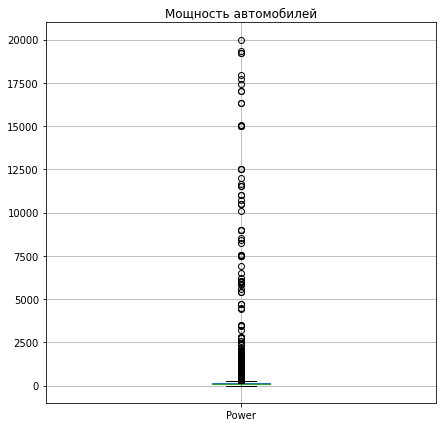

In [ ]:
df.boxplot(['Power'], figsize=(7,7))
plt.title('Мощность автомобилей')
plt.show()

In [ ]:
q = [0.1, 0.99]
df['Power'].quantile(q=q)

0.10     50.0
0.99    280.0
Name: Power, dtype: float64

Удалим строки с мощностью менее 50 и более 280

In [ ]:
df=df.query('Power > 49 & Power < 281')
df.shape

(254495, 15)

Удалим столбцы `PostalCode`, `DateCreated`, `RegistrationMonth`, `dateInt`, `RegistrationDate`. Для построения модели они нам не нужны. Хотя, возможно, по `PostalCode` можно найти город, но корреляция с целевым признаком слабая, наверное, город на цену не будет особо влиять.

In [ ]:
df.drop(['PostalCode', 'DateCreated', 'RegistrationMonth', 'dateInt', 'RegistrationDate'], axis=1, inplace=True)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...
354359,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


<AxesSubplot:title={'center':'Корреляция признаков'}>

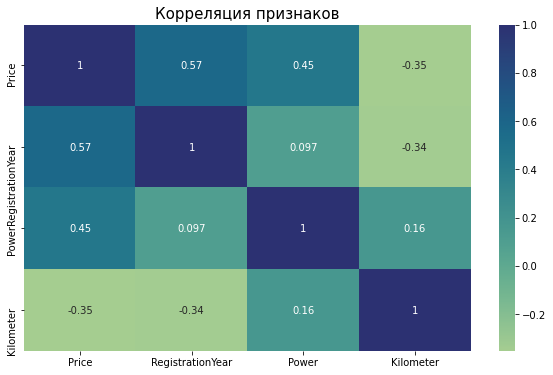

In [ ]:
plt.figure(figsize = (10, 6));
plt.title('Корреляция признаков', fontsize = 15)
sns.heatmap(df.corr(), annot = True, cmap="crest")

При предобработке данных:

Удалены 4 явных дубликата

У целевого признака были удалены значения с очень низкой(до 200 евро) и очень высокой(более 14600) ценами

Пропуски в VehicleType и Repaired заменены на 'unknown'.

Пропуски в Model удалены

Пропуски в FuelType и Gearbox заменены на наиболее часто встречающиеся в модели

RegistrationMonth и RegistrationYear были объеденины в один столбец RegistrationDate, удалены все строки с датами раньше 1965 года и позже апреля 2016

В столбце Power удалены данные со значениями меньше 49 и больше 280

После предобработки данных мультиколлинеарность не обнаружена

Также, после предобработки данных осталось 9 признаков, 1 целевой признак и 254495 строк

## Обучение моделей

### Разделение данных, кодирование признаков

Разделим данные на обучающую, валидационную и тестовою выборки

In [ ]:
target = df['Price']
features = df.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.4,
                                                                            random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(features_test,
                                                                            target_test,
                                                                            test_size=0.5,
                                                                            random_state=12345)


print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)


Размер обучающей выборки: (152697, 9)
Размер валидационной выборки: (50899, 9)
Размер тестовой выборки: (50899, 9)


Воспользуемся OHE кодированием категориальных признаков

In [ ]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [ ]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[ohe_features])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [ ]:
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

In [ ]:
features_train = features_train.drop(ohe_features, axis=1)

In [ ]:
features_train.head(5)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
77282,1996,136,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
189017,2011,90,60000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136206,1997,114,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254881,1989,124,150000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239488,2011,60,70000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Трансформируем валидационную выборку

In [ ]:
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

features_valid = features_valid.drop(ohe_features, axis=1)
features_valid.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
67243,1992,98,150000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9534,2005,200,125000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
120213,1968,145,40000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
229579,2005,150,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201780,2000,75,125000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Трансформируем тестовую выборку

In [ ]:
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)
features_test.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
36575,2007,68,60000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53405,2008,235,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333649,2007,233,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
135398,2008,111,20000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107022,2001,75,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Масштабируем признаки

In [ ]:
numeric = features_train.select_dtypes(include='int').columns.to_list() # создадим список признаков
print(numeric)

['RegistrationYear', 'Power', 'Kilometer']


In [ ]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(152697, 305)
(50899, 305)
(50899, 305)


In [ ]:
features_train.head(2)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
77282,-1.149041,0.424031,0.564155,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
189017,1.480566,-0.594695,-2.038722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
features_valid.head(2)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
67243,-1.850269,-0.417525,0.564155,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9534,0.428723,1.841389,-0.158866,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Функция для показателей предсказаний моделей

In [ ]:
def illustration_target(test,predict):
    mse = mean_squared_error(test,predict)
    plt.figure(figsize=(8, 5))
    pd.Series(predict).hist(bins=20, alpha=0.8)
    pd.Series(test).hist(bins=20, alpha=0.8)
    plt.text(17122,11225,'MSE={:.2f}'.format(mse))
    plt.text(17122,13225,'RMSE={:.2f}'.format(mse**0.5))
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий', y=1.05)
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')
    plt.subplot()
    plt.show()

### Линейная регрессия

In [ ]:
%%time
start_time_model_lr = timeit.default_timer()

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

elapsed_model_lr = round(timeit.default_timer() - start_time_model_lr, 2)

CPU times: user 11.3 s, sys: 4.53 s, total: 15.8 s
Wall time: 15.8 s


In [ ]:
%%time
start_time_pred_model_lr = timeit.default_timer()

pred_model_lr = model_lr.predict(features_valid)

elapsed_pred_model_lr = round(timeit.default_timer() - start_time_model_lr, 2)

CPU times: user 69.5 ms, sys: 87.9 ms, total: 157 ms
Wall time: 175 ms


In [ ]:
mse_model_lr = mean_squared_error(target_valid, pred_model_lr)
print("RMSE Линейной регрессии на валидационной выборке:", round((mse_model_lr) ** 0.5, 5))

RMSE Линейной регрессии на валидационной выборке: 1990.24177


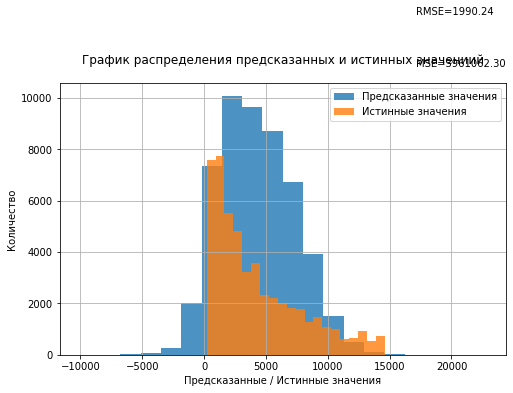

In [ ]:
illustration_target(target_valid, pred_model_lr)

### Дерево решений

In [ ]:
%%time
start_time_model_dtr = timeit.default_timer()

model_dtr = DecisionTreeRegressor(criterion='mse',
                              max_depth=10,
                              random_state=12345)
model_dtr.fit(features_train, target_train)

elapsed_model_dtr = timeit.default_timer() - start_time_model_dtr

CPU times: user 2.68 s, sys: 58.4 ms, total: 2.74 s
Wall time: 2.75 s


In [ ]:
%%time
start_time_pred_model_dtr = timeit.default_timer()

pred_model_dtr = model_dtr.predict(features_valid)

elapsed_pred_model_dtr = timeit.default_timer() - start_time_pred_model_dtr

CPU times: user 36.5 ms, sys: 16.3 ms, total: 52.8 ms
Wall time: 50.2 ms


In [ ]:
mse_model_dtr = mean_squared_error(target_valid, pred_model_dtr)
print("RMSE Дерева решений на валидационной выборке:", round((mse_model_dtr) ** 0.5, 5))

RMSE Дерева решений на валидационной выборке: 1595.74815


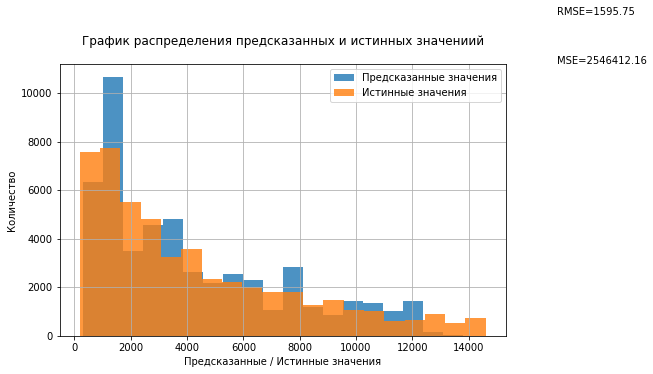

In [ ]:
illustration_target(target_valid, pred_model_dtr)

###  LightGBM разделение данных, кодирование

Разделим данные

In [ ]:
target = df['Price']
features = df.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25,
                                                                            random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(features_test,
                                                                            target_test,
                                                                            test_size=0.5,
                                                                            random_state=12345)


print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)


Размер обучающей выборки: (190871, 9)
Размер валидационной выборки: (31812, 9)
Размер тестовой выборки: (31812, 9)


Закодируем числовые признаки

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
40235,sedan,-0.449003,auto,-0.239550,other,0.564661,petrol,fiat,yes
132696,small,-0.799548,manual,-0.926165,lupo,0.564661,petrol,volkswagen,unknown
335328,sedan,0.252086,auto,3.127075,5er,0.564661,gasoline,bmw,no
68011,coupe,0.602631,manual,1.842442,tt,0.564661,petrol,audi,no
224371,small,0.076814,manual,-1.147653,micra,-1.747984,petrol,nissan,no


Закодируем категориальные признаки

In [ ]:
features_train_gbm = features_train.copy()
features_valid_gbm = features_valid.copy()
features_test_gbm = features_test.copy()
category_features_gbm = ohe_features
encoder = OrdinalEncoder()
encoder.fit(features_train_gbm[category_features_gbm])
features_train_gbm[category_features_gbm] = encoder.transform(features_train_gbm[category_features_gbm])
features_valid_gbm[category_features_gbm] = encoder.transform(features_valid_gbm[category_features_gbm])
features_test_gbm[category_features_gbm] = encoder.transform(features_test_gbm[category_features_gbm])

features_train_gbm.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
40235,4.0,-0.449003,0.0,-0.239550,166.0,0.564661,6.0,9.0,2.0
132696,5.0,-0.799548,1.0,-0.926165,143.0,0.564661,6.0,37.0,1.0
335328,4.0,0.252086,0.0,3.127075,15.0,0.564661,2.0,2.0,0.0
68011,2.0,0.602631,1.0,1.842442,223.0,0.564661,6.0,1.0,0.0
224371,5.0,0.076814,1.0,-1.147653,151.0,-1.747984,6.0,23.0,0.0


In [ ]:
features_valid_gbm.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
242710,4.0,-0.449003,1.0,-0.018062,103.0,-0.158040,6.0,10.0,0.0
114553,1.0,-1.851183,1.0,0.358469,20.0,0.564661,6.0,1.0,0.0
40610,8.0,-0.098459,1.0,0.734999,11.0,0.564661,2.0,2.0,0.0
239051,4.0,-0.449003,0.0,-0.350295,116.0,0.564661,6.0,37.0,0.0
36128,4.0,0.252086,1.0,-0.350295,29.0,0.564661,2.0,1.0,0.0


In [ ]:
features_test_gbm.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
238086,5.0,-1.150093,1.0,-0.926165,173.0,0.564661,6.0,37.0,0.0
56169,8.0,-0.449003,0.0,0.181278,104.0,0.564661,6.0,33.0,2.0
66756,5.0,0.427359,1.0,-1.391291,173.0,0.564661,6.0,37.0,0.0
89683,8.0,-0.449003,1.0,-0.483188,227.0,0.564661,2.0,38.0,0.0
93864,8.0,-0.098459,0.0,1.022934,59.0,0.564661,6.0,20.0,0.0


### LightGBM Regressor

In [ ]:
%%time
start_time_gbm = timeit.default_timer()

gbm = LGBMRegressor(learning_rate=0.4,
                      num_leaves=100,
                      random_state=12345)
gbm.fit(features_train_gbm, target_train)

elapsed_gbm = timeit.default_timer() - start_time_gbm

CPU times: user 6.61 s, sys: 0 ns, total: 6.61 s
Wall time: 6.6 s


In [ ]:
%%time
start_time_gbm_predict = timeit.default_timer()

gbm_predict = gbm.predict(features_valid_gbm)

elapsed_gbm_predict = timeit.default_timer() - start_time_gbm_predict

CPU times: user 234 ms, sys: 0 ns, total: 234 ms
Wall time: 285 ms


In [ ]:
mse_gbm = mean_squared_error(target_valid, gbm_predict)
print("RMSE LGBMRegressor на валидационной выборке:", round((mse_gbm) ** 0.5, 5))

RMSE LGBMRegressor на валидационной выборке: 1268.27704


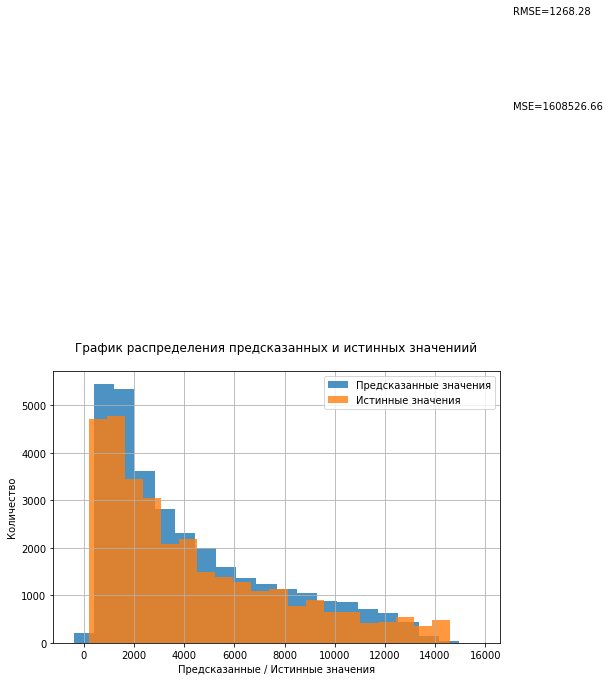

In [ ]:
illustration_target(target_valid, gbm_predict)

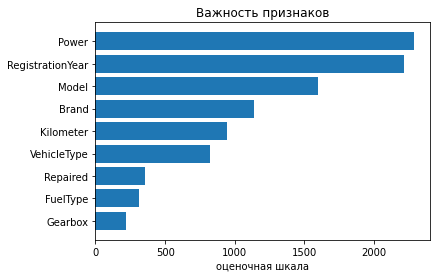

In [ ]:
features=features_valid.columns
importances = gbm.feature_importances_
indices = np.argsort(importances)

plt.figure()
plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('оценочная шкала')
plt.show()

### CatBoost Regressor

In [ ]:
ohe_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [ ]:
%%time
start_time_cat = timeit.default_timer()

cat = CatBoostRegressor(learning_rate=0.5, random_state=12345, verbose=False)
cat.fit(features_train, target_train, cat_features=ohe_features)

elapsed_cat = timeit.default_timer() - start_time_cat

CPU times: user 2min 48s, sys: 1.03 s, total: 2min 49s
Wall time: 2min 51s


In [ ]:
%%time
start_time_cat_predict = timeit.default_timer()

cat_predict = cat.predict(features_valid)

elapsed_cat_predict = timeit.default_timer() - start_time_cat_predict

CPU times: user 354 ms, sys: 34 µs, total: 354 ms
Wall time: 354 ms


In [ ]:
mse_cat = mean_squared_error(target_valid, cat_predict)
print("RMSE CatBoostRegressor на валидационной выборке:", round((mse_cat) ** 0.5, 5))

RMSE CatBoostRegressor на валидационной выборке: 1267.14959


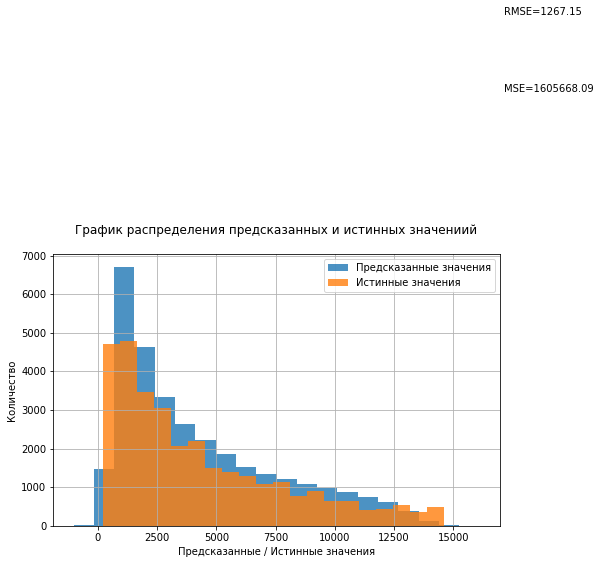

In [ ]:
illustration_target(target_valid, cat_predict)

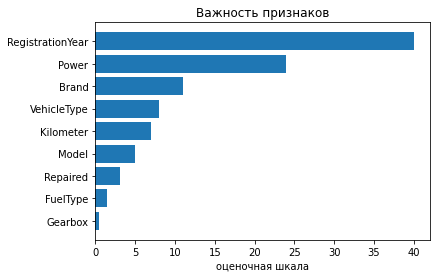

In [ ]:
features=features_valid.columns
importances = cat.feature_importances_
indices = np.argsort(importances)

plt.figure()
plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('оценочная шкала')
plt.show()

## Анализ моделей

In [ ]:
rmse_model_lr=round((mse_model_lr) ** 0.5, 5)
rmse_model_dtr=round((mse_model_dtr) ** 0.5, 5)
rmse_gbm=round((mse_gbm) ** 0.5, 5)
rmse_cat=round((mse_cat) ** 0.5, 5)

In [ ]:
df = [[elapsed_model_lr, elapsed_pred_model_lr, rmse_model_lr],
     [elapsed_model_dtr, elapsed_pred_model_dtr, rmse_model_dtr],
     [elapsed_gbm, elapsed_gbm_predict, rmse_gbm],
     [elapsed_cat, elapsed_cat_predict, rmse_cat]]
model = ['LinearRegression', 'DecisionTreeRegressor', 'LGBMRegressor', 'CatBoostRegressor']


In [ ]:
a = pd.DataFrame(data=df, index=model, columns=['fit_time', 'predict_time', 'RMSE'])
a

,fit_time,predict_time,RMSE
LinearRegression,15.850000,16.030000,1990.24177
DecisionTreeRegressor,2.750447,0.050127,1595.74815
LGBMRegressor,6.596974,0.284586,1268.27704
CatBoostRegressor,171.603470,0.354070,1267.14959


Хотя лучшее значение RMSE показала модель CatBoost, но лучшей моделью для заказчика по соотношению качества и времени исполнения является LightGBM Regressor.

### Тестирование модели

Проверим лучшую модель на тестовой выборке.

In [ ]:
gbm.fit(features_train_gbm, target_train)
gbm_predict_test = gbm.predict(features_test_gbm)

In [ ]:
mse_gbm_test = mean_squared_error(target_test, gbm_predict_test)
print("RMSE LGBMRegressor на тестовой выборке:", round((mse_gbm_test) ** 0.5, 5))

RMSE LGBMRegressor на тестовой выборке: 1369.65207


## Вывод

<p>Сервис по продаже автомобилей с пробегом &laquo;Не бит, не крашен&raquo; разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.
    
В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо было построить модель для определения стоимости.</p>
<p>Заказчику важны:</p>
<ul>
<li>качество предсказания;</li>
<li>скорость предсказания;</li>
<li>время обучения.</li>
</ul>
<p><strong>Признаки</strong></p>
<p><code>DateCrawled</code>&nbsp;&mdash; дата скачивания анкеты из базы</p>
<p><code>VehicleType</code>&nbsp;&mdash; тип автомобильного кузова</p>
<p><code>RegistrationYear</code>&nbsp;&mdash; год регистрации автомобиля</p>
<p><code>Gearbox</code>&nbsp;&mdash; тип коробки передач</p>
<p><code>Power</code>&nbsp;&mdash; мощность (л. с.)</p>
<p><code>Model</code>&nbsp;&mdash; модель автомобиля</p>
<p><code>Kilometer</code>&nbsp;&mdash; пробег (км)</p>
<p><code>RegistrationMonth</code>&nbsp;&mdash; месяц регистрации автомобиля</p>
<p><code>FuelType</code>&nbsp;&mdash; тип топлива</p>
<p><code>Brand</code>&nbsp;&mdash; марка автомобиля</p>
<p><code>Repaired</code>&nbsp;&mdash; была машина в ремонте или нет</p>
<p><code>DateCreated</code>&nbsp;&mdash; дата создания анкеты</p>
<p><code>NumberOfPictures</code>&nbsp;&mdash; количество фотографий автомобиля</p>
<p><code>PostalCode</code>&nbsp;&mdash; почтовый индекс владельца анкеты (пользователя)</p>
<p><code>LastSeen</code>&nbsp;&mdash; дата последней активности пользователя</p>
<p><strong>Целевой признак</strong></p>
<p><code>Price</code>&nbsp;&mdash; цена (евро)</p>
<p>В результате исследования данных были обнаружены 4 явных дубликата, пропуски, нулевые значения и выбросы в данных. Мультиколлинеарность не обнаружена.</p>
<p>При предобработке данных:</p>
<ul>
<li>Удалены 4 явных дубликата</li>
<li>У целевого признака были удалены значения с очень низкой(до 200 евро) и очень высокой(более 14600) ценами</li>
<li>Пропуски в VehicleType и Repaired заменены на 'unknown'</li>
<li>Пропуски в Model удалены</li>
<li>Пропуски в FuelType и Gearbox заменены на наиболее часто встречающиеся в модели</li>
<li>RegistrationMonth и RegistrationYear были объеденины в один столбец RegistrationDate, удалены все строки с датами раньше 1965 года и позже апреля 2016</li>
<li>В столбце Power удалены данные со значениями меньше 49 и больше 280</li>
<li>После предобработки данных мультиколлинеарность не обнаружена</li>
</ul>
<p>Также, после предобработки данных осталось 9 признаков, 1 целевой признак и 254495 строк.</p>
<p>В ходе работы были обучены 4 модели, перед этим признаки были закодированы и масштабированы по отдельно для Линейной регрессии и Дерева решений, отдельно для LightGbm, для CatBoost категориальные признаки были переданы "как есть".</p>
<p>    
Хотя лучшее значение RMSE показала модель CatBoost, но лучшей моделью для заказчика по соотношению качества и времени исполнения является LightGBM Regressor.</p>



<table class="dataframe" border="1">
<thead>
<tr>
<th>&nbsp;</th>
<th>fit_time</th>
<th>predict_time</th>
<th>RMSE</th>
</tr>
</thead>
<tbody>
<tr>
<th>LinearRegression</th>
<td>9.530000</td>
<td>9.680000</td>
<td>1990.24177</td>
</tr>
<tr>
<th>DecisionTreeRegressor</th>
<td>4.134173</td>
<td>0.059706</td>
<td>1595.74815</td>
</tr>
<tr>
<th>LGBMRegressor</th>
<td>1.483422</td>
<td>0.140581</td>
<td>1268.27704</td>
</tr>
<tr>
<th>CatBoostRegressor</th>
<td>205.027869</td>
<td>0.362867</td>
<td>1267.14959</td>
</tr>
</tbody>
</table>

RMSE LGBMRegressor на тестовой выборке: 1369.65207